In [2]:
!pip -q install ultralytics opencv-python-headless

import os, json, shutil, glob, random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

from ultralytics import YOLO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.4 MB/s eta 0:00:00a 0:00:01
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
# =============================
# EDIT THESE PATHS ONLY
# =============================

RAW_ROOT = "/kaggle/input/xca-classification-haryshwa/arcade/syntax"  # <-- change if needed
ANN_ROOT = "/kaggle/input/xca-classification-haryshwa/arcade"         # <-- change if needed

TRAIN_JSON = os.path.join(ANN_ROOT, "train.json")
VAL_JSON   = os.path.join(ANN_ROOT, "val.json")

WORK_ROOT = "/kaggle/working"
OUT_ROOT  = os.path.join(WORK_ROOT, "arcade_yolo_paperprep")

# =============================
# Allowed classes (replace a,b,c with real IDs)
# =============================

ALLOWED_CLASSES = [6, 5, 2, 1, 3, 7, 13, 8, 16, 4, 20, 9, 15, 25, 17]  # <-- edit if needed
ALLOWED_SET = set(ALLOWED_CLASSES)

# Remap to contiguous IDs [0..K-1]
CLASS_ID_MAP = {cid: idx for idx, cid in enumerate(ALLOWED_CLASSES)}
NUM_CLASSES = len(ALLOWED_CLASSES)

print("Num classes:", NUM_CLASSES)
print("CLASS_ID_MAP:", CLASS_ID_MAP)


Num classes: 15
CLASS_ID_MAP: {6: 0, 5: 1, 2: 2, 1: 3, 3: 4, 7: 5, 13: 6, 8: 7, 16: 8, 4: 9, 20: 10, 9: 11, 15: 12, 25: 13, 17: 14}


In [4]:
import os, glob

# =============================
# Dataset root (based on your Kaggle sidebar)
# =============================
DATASET_ROOT = "/kaggle/input/xca-classification-haryshwa/arcade"
TASK = "syntax"   # <-- keep "syntax" for vessel labeling task

TASK_ROOT = os.path.join(DATASET_ROOT, TASK)

# =============================
# Auto-find annotation JSON files
# =============================
def find_json(split):
    cand = glob.glob(os.path.join(TASK_ROOT, split, "annotations", "*.json"))
    if len(cand) == 0:
        raise FileNotFoundError(f"No JSON found in {TASK_ROOT}/{split}/annotations/")
    return cand[0]  # if multiple, we’ll pick the first; we can refine if needed

TRAIN_JSON = find_json("train")
VAL_JSON   = find_json("val")

TRAIN_IMG_DIR = os.path.join(TASK_ROOT, "train", "images")
VAL_IMG_DIR   = os.path.join(TASK_ROOT, "val", "images")

print("✅ TASK_ROOT:", TASK_ROOT)
print("✅ TRAIN_JSON:", TRAIN_JSON)
print("✅ VAL_JSON  :", VAL_JSON)
print("✅ TRAIN_IMG_DIR:", TRAIN_IMG_DIR, "| exists:", os.path.exists(TRAIN_IMG_DIR))
print("✅ VAL_IMG_DIR  :", VAL_IMG_DIR, "| exists:", os.path.exists(VAL_IMG_DIR))


✅ TASK_ROOT: /kaggle/input/xca-classification-haryshwa/arcade/syntax
✅ TRAIN_JSON: /kaggle/input/xca-classification-haryshwa/arcade/syntax/train/annotations/train.json
✅ VAL_JSON  : /kaggle/input/xca-classification-haryshwa/arcade/syntax/val/annotations/val.json
✅ TRAIN_IMG_DIR: /kaggle/input/xca-classification-haryshwa/arcade/syntax/train/images | exists: True
✅ VAL_IMG_DIR  : /kaggle/input/xca-classification-haryshwa/arcade/syntax/val/images | exists: True


In [5]:
# =============================
# Count instances per category
# =============================

from collections import Counter
import json

with open(TRAIN_JSON, "r") as f:
    coco = json.load(f)

# Build category id -> name mapping
id_to_name = {c["id"]: c.get("name", "NO_NAME") for c in coco["categories"]}

# Count instances
instance_counter = Counter()

for ann in coco["annotations"]:
    cid = ann["category_id"]
    instance_counter[cid] += 1

# Print all categories (sorted by instance count)
print("\nInstance count per category (TRAIN split):\n")
print(f"{'ARCADE ID':<10} {'Category name':<20} {'# Instances':<12}")
print("-" * 45)

for cid, count in sorted(instance_counter.items(), key=lambda x: x[1], reverse=True):
    print(f"{cid:<10} {id_to_name.get(cid,'UNKNOWN'):<20} {count:<12}")

print("\nTotal annotations:", sum(instance_counter.values()))



Instance count per category (TRAIN split):

ARCADE ID  Category name        # Instances 
---------------------------------------------
6          6                    537         
5          5                    525         
2          2                    375         
1          1                    374         
3          3                    369         
7          7                    340         
13         11                   320         
8          8                    310         
16         13                   305         
4          4                    303         
20         16                   232         
9          9                    198         
15         12a                  129         
25         14b                  127         
17         14                   107         
10         9a                   70          
24         12b                  63          
14         12                   61          
18         14a                  49          
22       

In [6]:
# =============================
# Show mapping table (ARCADE → YOLO)
# =============================

with open(TRAIN_JSON, "r") as f:
    coco = json.load(f)

id_to_name = {c["id"]: c.get("name", "NO_NAME") for c in coco["categories"]}

print("\nFINAL vessel classes used (ARCADE → YOLO mapping):\n")
print(f"{'ARCADE ID':<10} {'Category name':<20} {'YOLO class':<10}")
print("-" * 45)

for arcade_id in ALLOWED_CLASSES:
    print(f"{arcade_id:<10} {id_to_name.get(arcade_id,'UNKNOWN'):<20} {CLASS_ID_MAP[arcade_id]:<10}")

print("\nTotal classes used:", NUM_CLASSES)



FINAL vessel classes used (ARCADE → YOLO mapping):

ARCADE ID  Category name        YOLO class
---------------------------------------------
6          6                    0         
5          5                    1         
2          2                    2         
1          1                    3         
3          3                    4         
7          7                    5         
13         11                   6         
8          8                    7         
16         13                   8         
4          4                    9         
20         16                   10        
9          9                    11        
15         12a                  12        
25         14b                  13        
17         14                   14        

Total classes used: 15


In [7]:
# =============================
# Keep ALL images that contain >=1 allowed-class instance
# =============================

with open(TRAIN_JSON, "r") as f:
    coco_train = json.load(f)

# image_id -> file info
train_id_to_img = {im["id"]: im for im in coco_train["images"]}

# find which images have at least one allowed annotation
kept_train_image_ids = set()

for ann in coco_train["annotations"]:
    if ann["category_id"] in ALLOWED_SET:
        kept_train_image_ids.add(ann["image_id"])

print("✅ Train images total in JSON:", len(train_id_to_img))
print("✅ Train images with >=1 allowed-class instance:", len(kept_train_image_ids))

# (Optional) show a few example filenames
example_ids = list(kept_train_image_ids)[:5]
print("\nExample kept train images:")
for iid in example_ids:
    print("-", train_id_to_img[iid]["file_name"])


✅ Train images total in JSON: 1000
✅ Train images with >=1 allowed-class instance: 1000

Example kept train images:
- 1.png
- 2.png
- 3.png
- 4.png
- 5.png


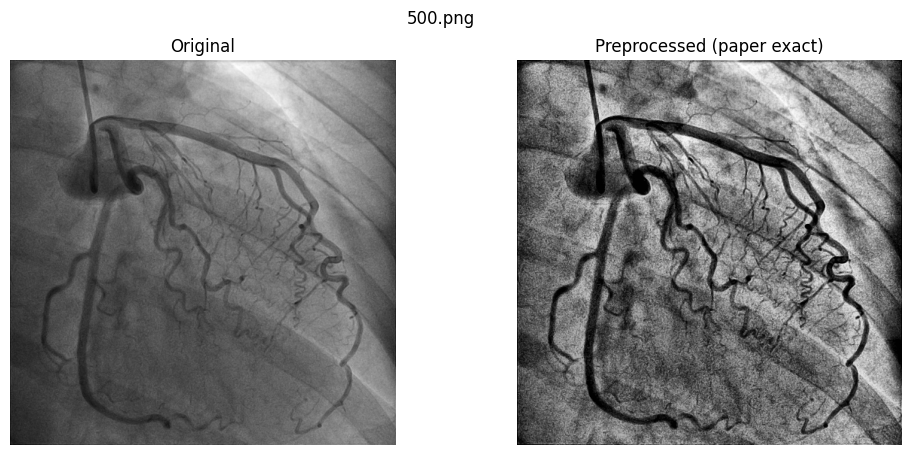

✅ Sample used: /kaggle/input/xca-classification-haryshwa/arcade/syntax/train/images/500.png


In [8]:
# =============================
# Paper-exact preprocessing + sanity check
# =============================

def preprocess_xca_paper(img_gray):
    """
    EXACT preprocessing used in the ARCADE research code.

    Steps:
    1) Invert image
    2) White top-hat on inverted image with 50x50 kernel
    3) Subtract top-hat result from ORIGINAL image
    4) Hard clip negative values to 0
    5) Apply CLAHE (clip=2.0, grid=8x8)
    """
    img_not = cv2.bitwise_not(img_gray)

    kernel = np.ones((50, 50), np.uint8)
    tophat = cv2.morphologyEx(img_not, cv2.MORPH_TOPHAT, kernel)

    raw_minus_topwhite = img_gray.astype(np.int32) - tophat.astype(np.int32)
    raw_minus_topwhite = np.maximum(raw_minus_topwhite, 0).astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(raw_minus_topwhite)

    return enhanced


# --- sanity check on one random train image (debug only) ---
sample_img_path = os.path.join(TRAIN_IMG_DIR, random.choice(os.listdir(TRAIN_IMG_DIR)))
img_bgr = cv2.imread(sample_img_path)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_pre = preprocess_xca_paper(img_gray)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1); plt.imshow(img_gray, cmap="gray"); plt.title("Original"); plt.axis("off")
plt.subplot(1,2,2); plt.imshow(img_pre, cmap="gray"); plt.title("Preprocessed (paper exact)"); plt.axis("off")
plt.suptitle(os.path.basename(sample_img_path))
plt.show()

print("✅ Sample used:", sample_img_path)


✅ Preprocessed shape: (512, 512, 3)
✅ dtype: uint8
✅ Range: 1 239


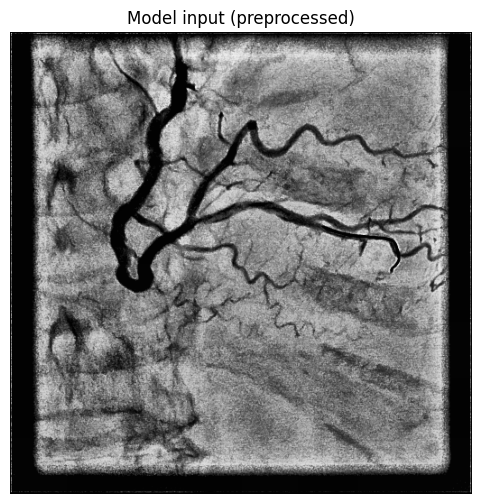

In [9]:
# =============================
# Unified loader: ALWAYS preprocess the same way
# =============================

def load_and_preprocess_for_model(img_path):
    """
    Loads an image from disk and applies ARCADE paper preprocessing.
    Returns a 3-channel BGR image ready for YOLO (uint8).
    """
    img_bgr = cv2.imread(img_path)
    if img_bgr is None:
        raise ValueError(f"Could not read image: {img_path}")

    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    img_pre  = preprocess_xca_paper(img_gray)

    # YOLO expects 3-channel images; convert grayscale -> BGR
    img_model = cv2.cvtColor(img_pre, cv2.COLOR_GRAY2BGR)
    return img_model


# Quick sanity check
test_path = os.path.join(TRAIN_IMG_DIR, random.choice(os.listdir(TRAIN_IMG_DIR)))
x = load_and_preprocess_for_model(test_path)

print("✅ Preprocessed shape:", x.shape)   # (H, W, 3)
print("✅ dtype:", x.dtype)               # uint8
print("✅ Range:", x.min(), x.max())

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(x, cv2.COLOR_BGR2RGB))
plt.title("Model input (preprocessed)")
plt.axis("off")
plt.show()


In [10]:
# =============================
# COCO polygon → YOLOv8-seg label line
# =============================

def coco_polygon_to_yolo_seg_line(polygon, yolo_class, img_w, img_h):
    """
    Convert ONE COCO polygon to a YOLOv8-seg label line.

    Inputs:
      polygon     : list [x1, y1, x2, y2, ..., xN, yN] (COCO format)
      yolo_class  : int (0..NUM_CLASSES-1)
      img_w, img_h: image width & height

    Output:
      str: "class x1 y1 x2 y2 ... xN yN" (all coords normalized to [0,1])
    """
    pts = np.array(polygon, dtype=np.float32).reshape(-1, 2)

    # normalize
    pts[:, 0] /= img_w
    pts[:, 1] /= img_h

    # clip just in case
    pts = np.clip(pts, 0.0, 1.0)

    flat = pts.reshape(-1)
    return str(yolo_class) + " " + " ".join(f"{v:.6f}" for v in flat)


# --- tiny sanity check (no files written) ---
# Fake polygon square in a 100x100 image
test_poly = [10,10, 90,10, 90,90, 10,90]
print(coco_polygon_to_yolo_seg_line(test_poly, yolo_class=0, img_w=100, img_h=100))


0 0.100000 0.100000 0.900000 0.100000 0.900000 0.900000 0.100000 0.900000


In [11]:
# =============================
# Build YOLOv8-seg dataset (paper-preprocessed images + filtered labels)
# =============================

def build_yolo_seg_split(coco_json_path, split_name, img_dir, out_root):
    with open(coco_json_path, "r") as f:
        coco = json.load(f)

    id_to_img = {im["id"]: im for im in coco["images"]}

    # group allowed annotations by image_id
    anns_by_img = {}
    for ann in coco["annotations"]:
        cid = ann["category_id"]
        if cid not in ALLOWED_SET:
            continue
        anns_by_img.setdefault(ann["image_id"], []).append(ann)

    out_img_dir = os.path.join(out_root, split_name, "images")
    out_lbl_dir = os.path.join(out_root, split_name, "labels")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    kept = 0
    for img_id, info in tqdm(id_to_img.items(), desc=f"Building {split_name}"):
        # Skip if no allowed anns for this image
        if img_id not in anns_by_img:
            continue

        file_name = info["file_name"]
        w, h = info["width"], info["height"]

        src_path = os.path.join(img_dir, file_name)
        if not os.path.exists(src_path):
            # fallback if file_name has subfolders in it
            src_path = os.path.join(img_dir, os.path.basename(file_name))
            if not os.path.exists(src_path):
                continue

        # --- preprocess image and save ---
        img_model = load_and_preprocess_for_model(src_path)  # paper exact
        out_img_path = os.path.join(out_img_dir, os.path.basename(file_name))
        cv2.imwrite(out_img_path, img_model)

        # --- write labels ---
        lines = []
        for ann in anns_by_img[img_id]:
            cid = ann["category_id"]
            yolo_cls = CLASS_ID_MAP[cid]

            seg = ann.get("segmentation", None)
            if seg is None or len(seg) == 0:
                continue

            # COCO polygon segmentation: list of polygons
            for poly in seg:
                if len(poly) < 6:
                    continue
                lines.append(coco_polygon_to_yolo_seg_line(poly, yolo_cls, w, h))

        if len(lines) == 0:
            # if no valid polygons, remove image to avoid empty label mismatch
            if os.path.exists(out_img_path):
                os.remove(out_img_path)
            continue

        out_lbl_path = os.path.join(out_lbl_dir, os.path.splitext(os.path.basename(file_name))[0] + ".txt")
        with open(out_lbl_path, "w") as f:
            f.write("\n".join(lines))

        kept += 1

    print(f"✅ {split_name}: kept {kept} images with labels")


# reset output dir
if os.path.exists(OUT_ROOT):
    shutil.rmtree(OUT_ROOT)
os.makedirs(OUT_ROOT, exist_ok=True)

# build train + val
build_yolo_seg_split(TRAIN_JSON, "train", TRAIN_IMG_DIR, OUT_ROOT)
build_yolo_seg_split(VAL_JSON, "val", VAL_IMG_DIR, OUT_ROOT)

print("✅ Dataset built at:", OUT_ROOT)
print("Train images:", len(glob.glob(os.path.join(OUT_ROOT, "train/images/*"))))
print("Train labels:", len(glob.glob(os.path.join(OUT_ROOT, "train/labels/*"))))
print("Val images:", len(glob.glob(os.path.join(OUT_ROOT, "val/images/*"))))
print("Val labels:", len(glob.glob(os.path.join(OUT_ROOT, "val/labels/*"))))


Building train: 100%|██████████| 1000/1000 [00:40<00:00, 24.47it/s]


✅ train: kept 1000 images with labels


Building val: 100%|██████████| 200/200 [00:07<00:00, 26.57it/s]

✅ val: kept 200 images with labels
✅ Dataset built at: /kaggle/working/arcade_yolo_paperprep
Train images: 1000
Train labels: 1000
Val images: 200
Val labels: 200


In [12]:
# =============================
# Create YOLO dataset YAML (arcade.yaml)
# =============================

# Use names from COCO categories (so your labels are meaningful)
with open(TRAIN_JSON, "r") as f:
    coco_train = json.load(f)

id_to_name = {c["id"]: c.get("name", "NO_NAME") for c in coco_train["categories"]}

# YOLO class index -> human-readable name (in the same order as ALLOWED_CLASSES)
yolo_names = [id_to_name.get(cid, f"class_{cid}") for cid in ALLOWED_CLASSES]

yaml_path = os.path.join(OUT_ROOT, "arcade.yaml")

yaml_txt = f"""path: {OUT_ROOT}
train: train/images
val: val/images

names:
"""
for i, name in enumerate(yolo_names):
    yaml_txt += f"  {i}: {name}\n"

with open(yaml_path, "w") as f:
    f.write(yaml_txt)

print("✅ YAML saved at:", yaml_path)
print("\n--- arcade.yaml ---")
print(yaml_txt)


✅ YAML saved at: /kaggle/working/arcade_yolo_paperprep/arcade.yaml

--- arcade.yaml ---
path: /kaggle/working/arcade_yolo_paperprep
train: train/images
val: val/images

names:
  0: 6
  1: 5
  2: 2
  3: 1
  4: 3
  5: 7
  6: 11
  7: 8
  8: 13
  9: 4
  10: 16
  11: 9
  12: 12a
  13: 14b
  14: 14



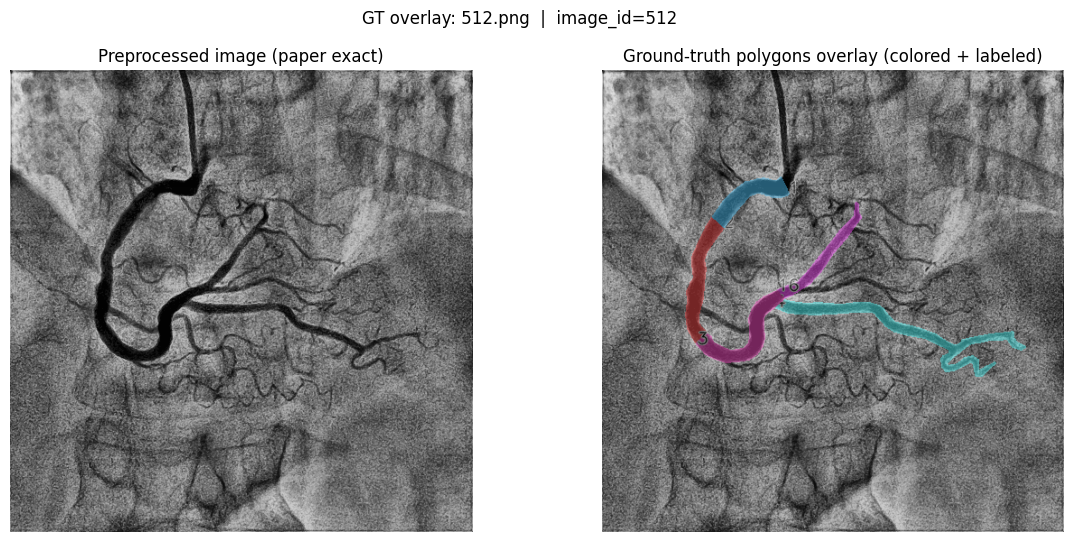

✅ Image: /kaggle/input/xca-classification-haryshwa/arcade/syntax/train/images/512.png
✅ Num annotations on this image: 6
✅ SHOW_ONLY_SELECTED: True


In [13]:
# =============================
# GT sanity check: draw COCO polygons on preprocessed image
# =============================

import json, os, random
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load COCO train annotations
with open(TRAIN_JSON, "r") as f:
    coco_train = json.load(f)

# Maps
id_to_img = {im["id"]: im for im in coco_train["images"]}
id_to_name = {c["id"]: c.get("name", "NO_NAME") for c in coco_train["categories"]}

# Group annotations by image_id (ALL categories for now)
anns_by_img = {}
for ann in coco_train["annotations"]:
    anns_by_img.setdefault(ann["image_id"], []).append(ann)

# Pick a random image that has annotations
img_id = random.choice(list(anns_by_img.keys()))
info = id_to_img[img_id]
img_path = os.path.join(TRAIN_IMG_DIR, info["file_name"])
if not os.path.exists(img_path):
    img_path = os.path.join(TRAIN_IMG_DIR, os.path.basename(info["file_name"]))

# Load + preprocess (paper exact)
img_bgr_raw = cv2.imread(img_path)
img_gray = cv2.cvtColor(img_bgr_raw, cv2.COLOR_BGR2GRAY)
img_pre = preprocess_xca_paper(img_gray)
base = cv2.cvtColor(img_pre, cv2.COLOR_GRAY2BGR)  # draw on this

# Palette (BGR)
PALETTE = [
    (255,  80,  80), ( 80, 255,  80), ( 80,  80, 255),
    (255, 200,  80), (200,  80, 255), ( 80, 255, 200),
    (255, 120, 200), (120, 255, 120), (120, 120, 255),
    (255, 255,  80), (255,  80, 255), ( 80, 255, 255),
    (200, 200, 200), (255, 160,  60), ( 60, 160, 255),
    (160,  60, 255), ( 60, 255, 160), (255,  60, 160),
]

# If you only want to visualize your selected classes, set this True
SHOW_ONLY_SELECTED = True

overlay = base.copy()

for ann in anns_by_img[img_id]:
    cid = ann["category_id"]
    if SHOW_ONLY_SELECTED and cid not in ALLOWED_SET:
        continue

    seg = ann.get("segmentation", None)
    if not seg:
        continue

    # color per class (stable)
    # If class is in your allowed list, map via CLASS_ID_MAP; else fall back to cid
    if cid in ALLOWED_SET:
        color_idx = CLASS_ID_MAP[cid]
    else:
        color_idx = cid
    color = PALETTE[color_idx % len(PALETTE)]

    for poly in seg:
        if len(poly) < 6:
            continue

        pts = np.array(poly, dtype=np.int32).reshape(-1, 2)

        # fill with transparency
        cv2.fillPoly(overlay, [pts], color)
        # contour for crisp boundary
        cv2.polylines(overlay, [pts], isClosed=True, color=color, thickness=2)

        # label near first point
        x0, y0 = pts[0]
        label = id_to_name.get(cid, str(cid))
        cv2.putText(overlay, label, (x0, y0),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2, cv2.LINE_AA)
        cv2.putText(overlay, label, (x0, y0),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,0), 1, cv2.LINE_AA)

# alpha blend overlay onto base
alpha = 0.45
out = cv2.addWeighted(overlay, alpha, base, 1 - alpha, 0)

# Show
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(cv2.cvtColor(base, cv2.COLOR_BGR2RGB))
plt.title("Preprocessed image (paper exact)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB))
plt.title("Ground-truth polygons overlay (colored + labeled)")
plt.axis("off")

plt.suptitle(f"GT overlay: {os.path.basename(img_path)}  |  image_id={img_id}")
plt.show()

print("✅ Image:", img_path)
print("✅ Num annotations on this image:", len(anns_by_img[img_id]))
print("✅ SHOW_ONLY_SELECTED:", SHOW_ONLY_SELECTED)


In [ ]:
from ultralytics import YOLO
import os

model = YOLO("yolov8m-seg.pt")

results = model.train(
    data=yaml_path,
    task="segment",
    imgsz=896,
    epochs=50,
    batch=8,
    device=0,
    workers=2,

    # FORCE saving to a known place:
    project="/kaggle/working/runs_arcade",
    name="yolov8m_seg_sanity",
    exist_ok=True,

    save=True,          # ensure saving is enabled
    save_period=1,      # save every epoch (so even if it crashes later, you have weights)

    cache=True,
    optimizer="AdamW",
    lr0=1e-3,
    cos_lr=True,
    close_mosaic=2
)

print("✅ Sanity training complete. Check /kaggle/working/runs_arcade/")


Ultralytics 8.4.10 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 14913MiB)
engine/trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=2, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/arcade_yolo_paperprep/arcade.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=896, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=yolov8m_seg_sanity, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=T

In [ ]:
import os

weights_dir = "/kaggle/working/runs_arcade/yolov8m_seg_sanity/weights"
print("Weights dir exists:", os.path.exists(weights_dir))
print("Contents:", os.listdir(weights_dir))


In [ ]:
from ultralytics import YOLO

weights_path = "/kaggle/working/runs_arcade/yolov8m_seg_sanity/weights/last.pt"
model_trained = YOLO(weights_path)

print("✅ Loaded trained model from:", weights_path)


In [ ]:
# =============================
# Fix: predict_and_overlay with mask resizing
# =============================

import numpy as np, cv2

def predict_and_overlay(image_path, model, conf=0.25, imgsz=896):
    """
    Robust inference overlay:
    - preprocess image (paper exact)
    - predict
    - if mask size != image size, resize mask to match image before overlay
    """
    inp_bgr = load_and_preprocess_for_model(image_path)
    H, W = inp_bgr.shape[:2]

    pred = model.predict(source=inp_bgr, conf=conf, imgsz=imgsz, verbose=False)[0]
    overlay = inp_bgr.copy()

    if pred.masks is None or pred.boxes is None:
        return cv2.cvtColor(inp_bgr, cv2.COLOR_BGR2RGB), cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

    masks = pred.masks.data.cpu().numpy()               # (N,h,w)
    classes = pred.boxes.cls.cpu().numpy().astype(int)  # (N,)
    scores  = pred.boxes.conf.cpu().numpy()             # (N,)

    for i in range(len(masks)):
        cls = classes[i]
        score = scores[i]
        color = PALETTE[cls % len(PALETTE)]

        m = masks[i]

        # ✅ resize mask to match overlay image size if needed
        if m.shape[0] != H or m.shape[1] != W:
            m = cv2.resize(m, (W, H), interpolation=cv2.INTER_NEAREST)

        mask = m > 0.5
        if mask.sum() < 20:
            continue

        overlay[mask] = (0.65*np.array(color) + 0.35*overlay[mask]).astype(np.uint8)

        mask_u8 = (mask.astype(np.uint8) * 255)
        contours, _ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, color, 2)

        ys, xs = np.where(mask)
        cx, cy = int(xs.mean()), int(ys.mean())
        label = f"{YOLO_CLASS_NAMES[cls]} {score:.2f}"

        cv2.putText(overlay, label, (cx, cy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (255,255,255), 2, cv2.LINE_AA)
        cv2.putText(overlay, label, (cx, cy),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,0,0), 1, cv2.LINE_AA)

    return cv2.cvtColor(inp_bgr, cv2.COLOR_BGR2RGB), cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)

print("✅ Updated predict_and_overlay() with mask resizing")


In [ ]:
# =============================
# Demo cell: set any image path and get colored + labeled vessel masks
# =============================

import os
import matplotlib.pyplot as plt
from ultralytics import YOLO

# 1) Load trained weights (change if you used best.pt)
WEIGHTS_PATH = "/kaggle/working/runs_arcade/yolov8m_seg_sanity/weights/last.pt"
assert os.path.exists(WEIGHTS_PATH), f"Weights not found: {WEIGHTS_PATH}"

model_trained = YOLO(WEIGHTS_PATH)
print("✅ Loaded model:", WEIGHTS_PATH)

# 2) Choose ANY image you want here (train/val/test/or your uploaded image)
# Example test image (update filename as needed)
CUSTOM_IMG_PATH = "/kaggle/input/xca-classification-haryshwa/arcade/syntax/test/images/101.png"
assert os.path.exists(CUSTOM_IMG_PATH), f"Image not found: {CUSTOM_IMG_PATH}"

# 3) Predict + overlay
inp_rgb, overlay_rgb = predict_and_overlay(
    CUSTOM_IMG_PATH,
    model_trained,
    conf=0.05,   # lower for early training; raise later (0.2–0.35) when model is good
    imgsz=896
)

# 4) Show result
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.imshow(inp_rgb)
plt.title("Model input (paper-preprocessed)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(overlay_rgb)
plt.title("Prediction (colored + labeled masks)")
plt.axis("off")

plt.suptitle(os.path.basename(CUSTOM_IMG_PATH))
plt.show()

print("✅ Done:", CUSTOM_IMG_PATH)


In [ ]:
# =============================
# FINAL DEMO CELL:
# Raw → Preprocessed → GT (ARCADE labels) → Prediction (clean + ARCADE labels)
# Works for RANDOM or CUSTOM, and loads GT for CUSTOM too.
# =============================

import json, numpy as np, cv2, os, random
import matplotlib.pyplot as plt
from ultralytics import YOLO

# ---------- CONFIG ----------
MODE = "custom"     # "random" or "custom"
SPLIT = "test"      # important when MODE="custom" and you pick from test/val/train
CUSTOM_IMG_PATH = "/kaggle/input/xca-classification-haryshwa/arcade/syntax/test/images/106.png"

CONF = 0.10
IMGSZ = 896
IOU_THR = 0.55

WEIGHTS_PATH = "/kaggle/working/runs_arcade/yolov8m_seg_sanity/weights/best.pt"  # use best.pt
# ----------------------------

assert os.path.exists(WEIGHTS_PATH), f"Weights not found: {WEIGHTS_PATH}"
model = YOLO(WEIGHTS_PATH)

def get_split_paths(split):
    split = split.lower()
    if split == "train":
        return TRAIN_JSON, TRAIN_IMG_DIR
    elif split == "val":
        return VAL_JSON, VAL_IMG_DIR
    elif split == "test":
        return find_json("test"), os.path.join(TASK_ROOT, "test", "images")
    else:
        raise ValueError("SPLIT must be 'train', 'val', or 'test'")

def build_coco_maps(coco):
    """Build maps for filename->image_id and id->name from COCO JSON."""
    fname_to_imgid = {os.path.basename(im["file_name"]): im["id"] for im in coco["images"]}
    id_to_name = {c["id"]: c.get("name", str(c["id"])) for c in coco["categories"]}
    return fname_to_imgid, id_to_name

def get_gt_for_image(coco, image_id):
    """Get GT anns for an image_id filtered to ALLOWED_SET."""
    return [a for a in coco["annotations"] if a["image_id"] == image_id and a["category_id"] in ALLOWED_SET]

def mask_iou(a, b):
    inter = np.logical_and(a, b).sum()
    union = np.logical_or(a, b).sum()
    return inter / (union + 1e-9)

# ---------- Load COCO JSON for the chosen split ----------
coco_json, img_dir = get_split_paths(SPLIT)
with open(coco_json, "r") as f:
    coco = json.load(f)

fname_to_imgid, id_to_name = build_coco_maps(coco)

# YOLO index -> ARCADE category_id  (e.g., 0->6, 1->5, ...)
YOLO_TO_ARCADE = {CLASS_ID_MAP[cid]: cid for cid in CLASS_ID_MAP.keys()}

# ---------- Pick image + GT anns ----------
gt_anns = None

if MODE == "random":
    # build anns_by_img for fast random sampling
    anns_by_img = {}
    for ann in coco["annotations"]:
        if ann["category_id"] in ALLOWED_SET:
            anns_by_img.setdefault(ann["image_id"], []).append(ann)

    img_id = random.choice(list(anns_by_img.keys()))
    # find file_name for this id
    id_to_img = {im["id"]: im for im in coco["images"]}
    info = id_to_img[img_id]

    img_path = os.path.join(img_dir, info["file_name"])
    if not os.path.exists(img_path):
        img_path = os.path.join(img_dir, os.path.basename(info["file_name"]))

    gt_anns = anns_by_img.get(img_id, [])
    print(f"✅ MODE=random | SPLIT={SPLIT} | image_id={img_id} | #GT={len(gt_anns)}")
    print("✅ Image:", img_path)

elif MODE == "custom":
    img_path = CUSTOM_IMG_PATH
    assert os.path.exists(img_path), f"Custom image not found: {img_path}"

    fname = os.path.basename(img_path)
    img_id = fname_to_imgid.get(fname, None)

    if img_id is not None:
        gt_anns = get_gt_for_image(coco, img_id)
        print(f"✅ MODE=custom | SPLIT={SPLIT} | matched image_id={img_id} | #GT={len(gt_anns)}")
    else:
        gt_anns = None
        print(f"⚠️ MODE=custom | SPLIT={SPLIT} | filename {fname} not found in this split JSON → no GT")

    print("✅ Image:", img_path)

else:
    raise ValueError("MODE must be 'random' or 'custom'")

# ---------- Load RAW image ----------
raw_bgr = cv2.imread(img_path)
raw_gray = cv2.cvtColor(raw_bgr, cv2.COLOR_BGR2GRAY)

# ---------- Preprocess (paper exact) ----------
base = load_and_preprocess_for_model(img_path)  # BGR
H, W = base.shape[:2]

# ---------- Ground Truth overlay + ARCADE labels ----------
gt_vis = None
if gt_anns is not None and len(gt_anns) > 0:
    gt_overlay = base.copy()
    gt_labels = []  # (x, y, text)

    for ann in gt_anns:
        arcade_id = ann["category_id"]
        yolo_idx = CLASS_ID_MAP[arcade_id]
        color = PALETTE[yolo_idx % len(PALETTE)]
        label_txt = id_to_name.get(arcade_id, str(arcade_id))  # e.g., "6", "12a", "14b"

        for poly in ann.get("segmentation", []):
            if len(poly) < 6:
                continue
            pts = np.array(poly, dtype=np.int32).reshape(-1, 2)
            cv2.polylines(gt_overlay, [pts], True, color, 2)

            cx, cy = int(pts[:, 0].mean()), int(pts[:, 1].mean())
            gt_labels.append((cx, cy, label_txt))

    for j, (x, y, text) in enumerate(gt_labels):
        tx = x + (j % 4) * 16
        ty = y + (j // 4) * 16
        cv2.rectangle(gt_overlay, (tx-2, ty-14), (tx+42, ty+6), (0, 0, 0), -1)
        cv2.putText(gt_overlay, str(text), (tx, ty),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

    gt_vis = cv2.addWeighted(gt_overlay, 0.65, base, 0.35, 0)

# ---------- Prediction (mask-NMS) + ARCADE labels ----------
pred = model.predict(source=base, conf=CONF, imgsz=IMGSZ, verbose=False)[0]
pred_overlay = base.copy()

if pred.masks is not None and pred.boxes is not None:
    masks = pred.masks.data.cpu().numpy()
    classes = pred.boxes.cls.cpu().numpy().astype(int)   # YOLO indices 0..N-1
    scores  = pred.boxes.conf.cpu().numpy()

    # resize + binarize masks to H,W
    bin_masks = []
    for m in masks:
        if m.shape[0] != H or m.shape[1] != W:
            m = cv2.resize(m, (W, H), interpolation=cv2.INTER_NEAREST)
        bin_masks.append(m > 0.5)

    # sort by confidence
    order = np.argsort(-scores)

    # mask-NMS per class
    keep = []
    for idx in order:
        cls = classes[idx]
        m = bin_masks[idx]
        if m.sum() < 20:
            continue
        if any(classes[k] == cls and mask_iou(m, bin_masks[k]) > IOU_THR for k in keep):
            continue
        keep.append(idx)

    # draw masks + ARCADE label text
    for j, idx in enumerate(keep):
        yolo_cls = classes[idx]
        arcade_id = YOLO_TO_ARCADE.get(yolo_cls, None)
        label_txt = id_to_name.get(arcade_id, str(arcade_id)) if arcade_id is not None else str(yolo_cls)

        color = PALETTE[yolo_cls % len(PALETTE)]
        mask = bin_masks[idx]

        pred_overlay[mask] = (0.65*np.array(color) + 0.35*pred_overlay[mask]).astype(np.uint8)

        ys, xs = np.where(mask)
        if len(xs) == 0:
            continue
        cx, cy = int(xs.mean()), int(ys.mean())

        tx = cx + (j % 4) * 16
        ty = cy + (j // 4) * 16
        cv2.rectangle(pred_overlay, (tx-2, ty-14), (tx+42, ty+6), (0, 0, 0), -1)
        cv2.putText(pred_overlay, str(label_txt), (tx, ty),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

# ---------- Plot ----------
plt.figure(figsize=(22, 6))

plt.subplot(1, 4, 1)
plt.imshow(raw_gray, cmap="gray")
plt.title("Raw X-ray (before preprocessing)")
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(cv2.cvtColor(base, cv2.COLOR_BGR2RGB))
plt.title("Paper-preprocessed input")
plt.axis("off")

plt.subplot(1, 4, 3)
if gt_vis is None:
    plt.imshow(np.zeros((H, W, 3), dtype=np.uint8))
    plt.title("Ground Truth (not available)")
else:
    plt.imshow(cv2.cvtColor(gt_vis, cv2.COLOR_BGR2RGB))
    plt.title("Ground Truth (ARCADE labels)")
plt.axis("off")

plt.subplot(1, 4, 4)
plt.imshow(cv2.cvtColor(pred_overlay, cv2.COLOR_BGR2RGB))
plt.title("Prediction (ARCADE labels)")
plt.axis("off")

plt.suptitle(f"{os.path.basename(img_path)} | SPLIT={SPLIT} | MODE={MODE}")
plt.show()


In [ ]:
# =============================
# FINAL METRICS: Segmentation evaluation
# =============================

from ultralytics import YOLO

WEIGHTS_PATH = "/kaggle/working/runs_arcade/yolov8m_seg_sanity/weights/last.pt"
DATA_YAML = yaml_path   # arcade.yaml you already created

model = YOLO(WEIGHTS_PATH)

metrics = model.val(
    data=DATA_YAML,
    task="segment",
    imgsz=896,
    conf=0.25,     # evaluation confidence
    iou=0.50,      # standard IoU threshold
    split="val"    # or "test" if test annotations exist
)

print("✅ Evaluation complete")
